<a href="https://colab.research.google.com/github/jfgf11/Examen-2-Machine/blob/master/examen2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Examen 2




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#Instalación

In [2]:
!pip install pyEDFlib
!pip install progressbar2

     |████████████████████████████████| 1.1MB 2.4MB/s 
  Created wheel for pyEDFlib: filename=pyEDFlib-0.1.15-cp36-cp36m-linux_x86_64.whl size=920114 sha256=4157c75cc3346e24e600126df3bccc892acc76c0abc70749609ab3054b65e1b1
  Stored in directory: /root/.cache/pip/wheels/57/e3/8e/ce6236e9ada08b8ff91ef922c7418dbd66f1182dfbb22f8579
Successfully built pyEDFlib


#Librerías

In [0]:
%tensorflow_version 1.x
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import AveragePooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import pandas as pd
import pyedflib as pyedf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm
import progressbar

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix 
from sklearn.ensemble import AdaBoostClassifier

#Clases

In [0]:
#Esta no esta terminada.
class Resultados:
    def __init__(self, p_y_pred, p_y_true):#, p_labels):
        self.y_pred = p_y_pred
        self.y_true = p_y_true
        #self.labels = p_labels

    def darMatrizConfusion(self):
      cm = confusion_matrix(self.y_pred, self.y_true)#, self.labels)
      ax = plt.subplot()
      sns.heatmap(cm, annot = True, ax = ax); #annot=True to annotate cells
 
      # labels, title and ticks
      ax.set_xlabel('Predicted labels');
      ax.set_ylabel('True labels'); 
      ax.set_title('Confusion Matrix'); 
      ax.xaxis.set_ticklabels(['Clase0', 'Clase1', 'Clase2']);
      ax.yaxis.set_ticklabels(['Clase0', 'Clase1', 'Clase2']);

#Lectura de los Datos

In [4]:
filenameDatos = "drive/My Drive/sleep-cassette"
filenameDescripcion = "drive/My Drive/SC-subjects.xls"

ArchivoLightsOff=pd.read_excel(filenameDescripcion, sheet_name='Blad1')

TiempoLightsOff=ArchivoLightsOff["LightsOff"].values
TiempoLightsOffSegundos=TiempoLightsOff
HorasSuenio=8

for i in range (0, len(TiempoLightsOff)):
  segundos=int(TiempoLightsOff[i].hour) * 3600 + int(TiempoLightsOff[i].minute) * 60
  TiempoLightsOffSegundos[i]=segundos

listaArchivos = os.listdir(filenameDatos)

listaHypnograms = [i for i in listaArchivos if "Hypnogram" in i] 
listaPSGs = [i for i in listaArchivos if "PSG" in i]

listaHypnograms.sort()
listaPSGs.sort()

print("Importando datos...")

start = time.time()

Datos=np.zeros(3000)
Etiquetas=[0]

p = 0

for i in range(0,10):#len(listaHypnograms)):

  hyp = listaHypnograms[i]
  psg = listaPSGs[i]

  print("Hyp: {}, PSG: {}".format(hyp,psg))

  fileHyp = pyedf.EdfReader(filenameDatos + "/" + hyp)
  filePSG = pyedf.EdfReader(filenameDatos + "/" + psg)

  hypTime, hypDur, hypEtiqueta = fileHyp.readAnnotations()

  tiempoComienzo = fileHyp.starttime_hour*3600+fileHyp.starttime_minute*60+fileHyp.starttime_second
  offset=TiempoLightsOffSegundos[i]-tiempoComienzo
  if offset<0:
    offset+=24*3600
  LimiteSuperior=offset+HorasSuenio*3600
  ventana=30
  tiempo=offset
  j=0
  referenciaSenial=0
  FrecuenciaMuestreo = filePSG.getSampleFrequency(referenciaSenial)

  while tiempo<LimiteSuperior:
    if tiempo>hypTime[j]:
      j+=1
      
    ventanaMuestra = np.round(FrecuenciaMuestreo * ventana)
    muestraInicial = np.round(FrecuenciaMuestreo * tiempo)
    senial=filePSG.readSignal(referenciaSenial)
    senialActual=senial[muestraInicial:muestraInicial+ventanaMuestra]
    etiquetaActual=hypEtiqueta[j]
    Datos=np.vstack((Datos,senialActual))
    #print((Datos).shape)
    Etiquetas=np.vstack((Etiquetas,etiquetaActual))
    tiempo+=ventana
    p+=1

  fileHyp._close() 
  filePSG._close()
#print(listaHypnograms)
#print(listaPSGs)

print("Termino.")
print("Tiempo: {} segundos.".format(time.time()-start))

Importando datos...
Hyp: SC4001EC-Hypnogram.edf, PSG: SC4001E0-PSG.edf
(2, 3000)
(3, 3000)
(4, 3000)
(5, 3000)
(6, 3000)
(7, 3000)
(8, 3000)
(9, 3000)
(10, 3000)
(11, 3000)
(12, 3000)
(13, 3000)
(14, 3000)
(15, 3000)
(16, 3000)
(17, 3000)
(18, 3000)
(19, 3000)
(20, 3000)
(21, 3000)
(22, 3000)
(23, 3000)
(24, 3000)
(25, 3000)
(26, 3000)
(27, 3000)
(28, 3000)
(29, 3000)
(30, 3000)
(31, 3000)
(32, 3000)
(33, 3000)
(34, 3000)
(35, 3000)
(36, 3000)
(37, 3000)
(38, 3000)
(39, 3000)
(40, 3000)
(41, 3000)
(42, 3000)
(43, 3000)
(44, 3000)
(45, 3000)
(46, 3000)
(47, 3000)
(48, 3000)
(49, 3000)
(50, 3000)
(51, 3000)
(52, 3000)
(53, 3000)
(54, 3000)
(55, 3000)
(56, 3000)
(57, 3000)
(58, 3000)
(59, 3000)
(60, 3000)
(61, 3000)
(62, 3000)
(63, 3000)
(64, 3000)
(65, 3000)
(66, 3000)
(67, 3000)
(68, 3000)
(69, 3000)
(70, 3000)
(71, 3000)
(72, 3000)
(73, 3000)
(74, 3000)
(75, 3000)
(76, 3000)
(77, 3000)
(78, 3000)
(79, 3000)
(80, 3000)
(81, 3000)
(82, 3000)
(83, 3000)
(84, 3000)
(85, 3000)
(86, 3000)
(8

In [16]:
#filePSG = pyedf.EdfReader(filenameDatos + "/" + psg)
#filePSG._close()
filenameDatos + "/" + psg

'drive/My Drive/sleep-cassette/SC4002E0-PSG.edf'

In [0]:
np.save("Datos", Datos)
np.save("Etiquetas", Etiquetas)

In [15]:
with progressbar.ProgressBar(max_value=100) as bar:
  for i in tqdm(range(0,100)):
    #print("{}%".format(i), end="\r", flush=True)
    time.sleep(0.1)
    bar.update(i)

100%|██████████| 100/100 [00:10<00:00,  9.73it/s]
100% (100 of 100) |######################| Elapsed Time: 0:00:10 Time:  0:00:10


In [0]:
#Esto solo se corre una vez.
Etiquetas = Etiquetas[1:len(Etiquetas)]
Datos = Datos[1:Datos.shape[0]]

In [0]:
def eliminarClaseDesconocida(pDatos, pEtiquetas)
  et = []
  dat = []

  for i in range(0, len(pEtiquetas)):
    if pEtiquetas[i] != 'Sleep stage ?':
      np.append(dat, Datos[i,:])
      if pEtiquetas[i]=="Sleep stage W":
        np.append(et,0)
      elif pEtiquetas[i]=="Sleep stage 1":
        np.append(et,1)
      elif pEtiquetas[i]=="Sleep stage 2":
        np.append(et,2)
      elif pEtiquetas[i]=="Sleep stage 3":
        np.append(et,3)
      elif pEtiquetas[i]=="Sleep stage 4":
        np.append(et,4)
      elif pEtiquetas[i]=="Sleep stage R":
        np.append(et,5)
      else:
        print("Error. Hay una clase distinta a las definidas.")

  return et, dat

unosEtiquetas, unosDatos = eliminarClaseDesconocida(Datos, Etiquetas)

print(len(unosEtiquetas))
print(len(unosDatos))

#Entrenamiento del Modelo

#Implementación en Keras

In [0]:
def crearModelo(pTasa, pAlphas, pNumFiltros, pTamFiltros, pTamPooling, pNumNeuronas):
  #Numero de clases
  numClases = 6

  modelo = Sequential()

  #Esto corresponderia a la parte convolucional.
  modelo.add(Conv1D(pNumFiltros[0], pTamFiltros[0], activation = 'relu', input_shape = (3000,1)))
  modelo.add(MaxPooling1D(pTamPooling[0]))
  modelo.add(Conv1D(pNumFiltros[1], pTamFiltros[1], activation = 'relu'))
  modelo.add(AveragePooling1D(pTamPooling[1]))
  modelo.add(Conv1D(pNumFiltros[2], pTamFiltros[2], activation = 'relu'))
  #modelo.add(GlobalAveragePooling1D())
  modelo.add(MaxPooling1D(pTamPooling[2]))
  modelo.add(Flatten())

  #Esto corresponderia a la parte de red neuronal normalita. (Puse cualquier cosa por ahora)
  modelo.add(Dense(pNumNeuronas[0], activation = 'relu'))
  #modelo.add(Dropout(0.5))
  modelo.add(Dense(pNumNeuronas[1], activation = 'relu'))#, activity_regularizer=l2(pAlpha)))
  modelo.add(Dense(pNumNeuronas[2], activation = 'relu'))#, activity_regularizer=l2(pAlpha)))
  modelo.add(Dense(numClases, activation = 'softmax'))

  sgd = optimizers.SGD(lr = pTasa)
  adam = optimizers.Adam(learning_rate = pTasa)

  modelo.compile(loss='sparse_categorical_crossentropy', optimizer = adam, metrics = ['sparse_categorical_accuracy'])

  #modelo.summary()

  return modelo

In [0]:
x_train, x_test, y_train, y_test = train_test_split(unosDatos, unosEtiquetas , random_state = 0, test_size=0.10)
x_train = np.expand_dims(x_train, axis=2) # reshape (569, 30) to (569, 30, 1) 
x_test = np.expand_dims(x_test, axis=2) # reshape (569, 30) to (569, 30, 1) 

In [0]:
numFiltros = np.array([10, 5, 5])
tamFiltros = np.array([5, 5, 5])
tamPooling = np.array([6, 6, 6])

numNeuronas = np.array([25, 15, 5])

tasa = 0.001
alpha = 0.1

modelo = crearModelo(tasa, alpha, numFiltros, tamFiltros, tamPoolin ,numNeuronas)

epocas = 100
batchSize = 32
hist = modelo.fit(x_train, y_train, verbose = 0, validation_data=(x_test, y_test), epochs = epocas, batch_size = batchSize)

graficarHistoria(hist)

In [0]:
#modelo = crearModelo()
epocas = 100
batchSize = 32
hist = modelo.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = epocas, batch_size = batchSize)

#graficarHistoriaAccuracy(hist)
#graficarHistoriaValAccuracy(hist)
graficarHistoria(hist)

In [0]:
#Probando GridSearchCV
estimador = KerasClassifier(build_fn=crearModelo)

parametros = {'batch_size': [25,32],
              'epochs': [5,10],
              'optimizer': ['adam', 'rmsprop'],
              'pTasa': [0.01, 0.1]
              'pAlphas': [0.001]
              'pNumFiltros': numFiltros
              'pTamFiltros': tamFiltros
              'pTamPooling': tamPooling
              'pNumNeuronas': numNeuronas
              }
busqueda = GridSearchCV(estimator=estimador,
                           param_grid = parametros,
                           scoring = 'sparse_categorical_accuracy',
                           cv = 10)
busqueda = busqueda.fit(x_train, y_train)
mejoresParametros = busqueda.best_params_
mejorAccuracy = busqueda.best_score_

#Implementación en AdaBoost

In [0]:
epocas = 100
batchSize = 32

#Esto no se por que esta fallando.
estimadorBase = KerasClassifier(build_fn = crearModelo, epochs = epocas, batch_size = batchSize, verbose = 0)

print("Calculando...")

numEstimadores = 3
adaBoost = AdaBoostClassifier(base_estimator = estimadorBase, n_estimators = numEstimadores) #Variar otros parametros como la tasa de aprendizaje
adaBoost.fit(x_train, y_train)

print(confusion_matrix(adaBoost.predict(x_train),y_train))
print(confusion_matrix(adaBoost.predict(x_test),y_test))

#Resultados

In [0]:
def graficarHistoria(pHist):
  plt.plot(pHist.history['sparse_categorical_accuracy'], label = 'Accuracy Entrenamiento')
  plt.plot(hist.history['val_sparse_categorical_accuracy'], label = 'Accuracy Validacion')
  plt.xlabel('Epoca')
  plt.ylabel('Accuracy')
  plt.title("Accuracy vs Epoca")
  plt.legend()
  plt.show()

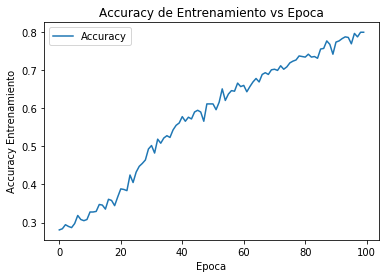

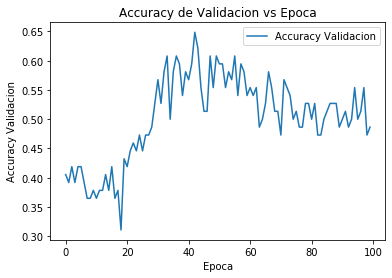

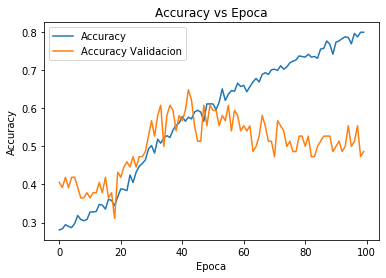

In [0]:
graficarHistoria(hist)